In [2]:
import numpy as np
import cv2 as cv
from PIL import Image
from src import *
import matplotlib.pyplot as plt
import pandas as pd

# Calibration

In [8]:
img = Image.open('./data/CALIB_ALEX_VEIKKA.png')
points = select_points(img)

# points = np.array([[498, 673],
    #    [398, 294],
    #    [463, 357],
    #    [594, 361],
    #    [664, 429],
    #    [735, 534],
    #    [812, 611],
    #    [756, 281],
    #    [932, 587]])

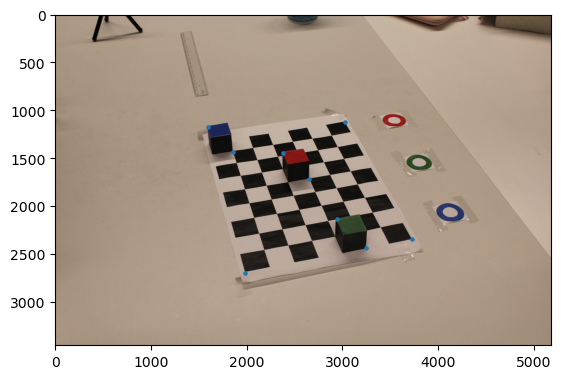

In [9]:
pts = points.copy()
plt.imshow(img)
plt.scatter(*pts.T, s=5)

In [10]:
points3 = pd.read_csv('./data/3d_points.csv', index_col=0)
points3 = points3.iloc[:, -3:].to_numpy()

M = calibrate_norm(points, points3)

In [11]:
intrinsic, extrinsic = extract_params(M)

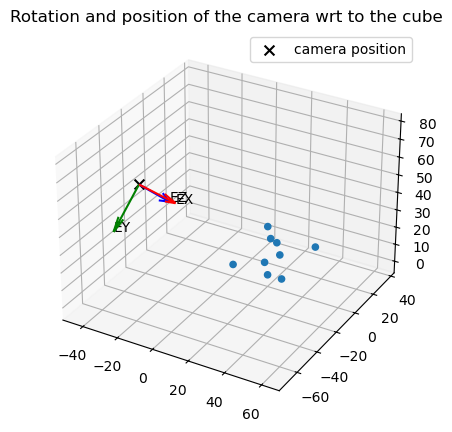

In [12]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(projection='3d')
ax.set_title("Rotation and position of the camera wrt to the cube")
ax.grid(True)
ax.scatter(*points3.T, alpha=1)
plot_frame(extrinsic, ax, name="E", l=25, s=50)

plt.legend()
plt.axis('equal')
plt.show()



# Robot detection

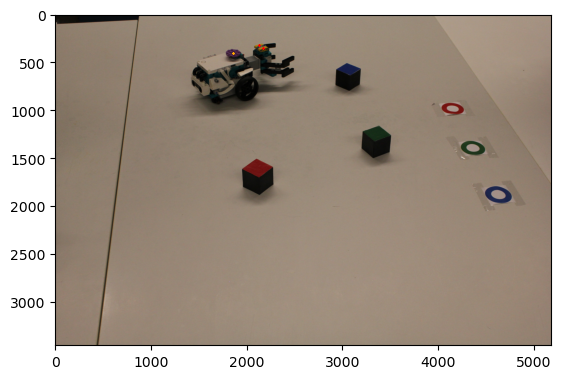

In [16]:
test = Image.open('./data/set2/images/image0003.png')
# test = Image.open('./data/showcase/bot.png')

centroids = locate_bot(test) - 4

disk, bar1, bar2 = centroids

plt.imshow(test, cmap='gray')
plt.scatter(*disk, c='orange', s=1, marker='x')
plt.scatter(*bar1, c='red', s=1, marker='x')
plt.scatter(*bar2, c='red', s=1, marker='x')

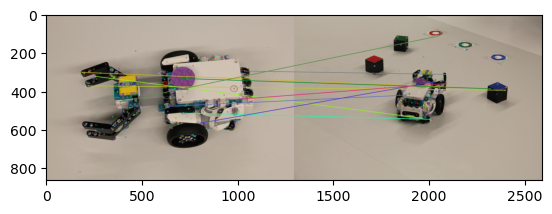

In [20]:
sift = cv.SIFT_create()
kp_tgt, des_tgt = sift.detectAndCompute(tgt,None)
kp_src, des_src = sift.detectAndCompute(src,None)

bf = cv.BFMatcher(cv.NORM_L2)
matches = bf.knnMatch(des_tgt, des_src, k=2)
matches = filter(lambda param: param[0].distance < 0.7*param[1].distance, matches)
matches = np.array([*matches])[:, 0]

tgt_pts = np.float32([kp_src[m.trainIdx].pt for m in matches])
src_pts = np.float32([kp_tgt[m.queryIdx].pt for m in matches])

tgt_pts /= np.linalg.norm(tgt_pts, axis=1, keepdims=True)
src_pts /= np.linalg.norm(src_pts, axis=1, keepdims=True)

# homography, mask = cv.findHomography(tgt_pts, src_pts, cv.RANSAC, 0.5)
# mask, _ = np.where(mask == 1)
# mask = mask.tolist()

canvas = cv.drawMatches(tgt, kp_tgt, src, kp_src, matches, None, matchesThickness=2)
plt.imshow(canvas)